# 06 - Evaluation Clean Domain

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/code_refactor/notebooks/06_evaluation_clean.ipynb)

This notebook implements the complete evaluation pipeline:
1. Load trained models (PatchCore & PaDiM)
2. Calibrate thresholds on Val-clean (F1-optimal)
3. Evaluate on Test-clean (image-level & pixel-level metrics)
4. Generate visualizations (ROC, PR curves, confusion matrices)

**Metrics computed:**
- Image-level: AUROC, AUPRC, F1, Accuracy, Precision, Recall
- Pixel-level: Pixel AUROC, PRO (Per-Region Overlap)

## 1. Setup & Configuration

In [ ]:
from google.colab import drive
from pathlib import Path
import os
import sys

drive.mount('/content/drive')

repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone -b code_refactor https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset location (direct from Drive)
DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')

# Output directories on Drive (User specific structure)
# Should be present if you have run previous notebooks
DRIVE_ROOT = Path('/content/drive/MyDrive/anomaly_detection_project')
PATCHCORE_MODELS_DIR = DRIVE_ROOT / '04_patchcore_clean_outputs'
PADIM_MODELS_DIR = DRIVE_ROOT / '05_padim_clean_outputs'

RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results' / 'evaluation_clean'
THRESHOLDS_DIR = PROJECT_ROOT / 'outputs' / 'thresholds' / 'evaluation_clean'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'evaluation_clean'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
THRESHOLDS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify dataset exists
if not DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATASET_PATH}\n"
        f"Please ensure mvtec_ad folder is in your Google Drive root."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project:   {PROJECT_ROOT}")
print(f"Dataset:   {DATASET_PATH}")
print(f"PatchCore: {PATCHCORE_MODELS_DIR}")
print(f"PaDiM:     {PADIM_MODELS_DIR}")
print(f"Results:   {RESULTS_DIR}")
print(f"Viz:       {VIZ_DIR}")

Install dependencies for PatchCore and PaDiM

In [2]:
!pip install faiss-cpu --quiet
!pip install anomalib --quiet


In [3]:
# Standard imports
import json
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Project imports
from src.utils.reproducibility import set_seed
from src.utils.config import load_config
from src.utils.paths import ProjectPaths
from src.data.splitter import load_splits
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.models.patchcore import PatchCore
from src.models.padim_wrapper import PadimWrapper
from src.utils.utils import custom_collate_fn

# Metrics imports
from src.metrics import (
    calibrate_threshold,
    calibrate_threshold_with_curve,
    ThresholdCalibrator,
    compute_image_metrics,
    compute_pixel_metrics,
    compute_roc_curve,
    compute_pr_curve,
    compute_confusion_matrix,
    aggregate_metrics,
    aggregate_pixel_metrics
)

# Set random seed for reproducibility
set_seed(42)

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Classes to evaluate
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Using device: cuda


## 2. Load Splits and Training Metadata

Load the clean dataset

In [4]:
# Load clean splits
SPLITS_PATH = paths.get_split_path('clean')
splits = load_splits(SPLITS_PATH)

# Print split statistics
print("\nSplit Statistics:")
print("-" * 50)
for class_name in CLASSES:
    train_n = len(splits[class_name]['train']['images'])
    val_n = len(splits[class_name]['val']['images'])
    test_n = len(splits[class_name]['test']['images'])

    val_normal = sum(1 for l in splits[class_name]['val']['labels'] if l == 0)
    val_anom = sum(1 for l in splits[class_name]['val']['labels'] if l == 1)
    test_normal = sum(1 for l in splits[class_name]['test']['labels'] if l == 0)
    test_anom = sum(1 for l in splits[class_name]['test']['labels'] if l == 1)

    print(f"{class_name}:")
    print(f"  Train: {train_n} (all normal)")
    print(f"  Val: {val_n} ({val_normal} normal, {val_anom} anomalous)")
    print(f"  Test: {test_n} ({test_normal} normal, {test_anom} anomalous)")


Split Statistics:
--------------------------------------------------
hazelnut:
  Train: 312 (all normal)
  Val: 100 (79 normal, 21 anomalous)
  Test: 89 (40 normal, 49 anomalous)
carpet:
  Train: 224 (all normal)
  Val: 82 (56 normal, 26 anomalous)
  Test: 91 (28 normal, 63 anomalous)
zipper:
  Train: 192 (all normal)
  Val: 83 (48 normal, 35 anomalous)
  Test: 116 (32 normal, 84 anomalous)


Load validation data computed in previous notebook and now used for threshold calibration.

In [5]:
# Load training metadata (contains validation predictions)
patchcore_metadata_path = RESULTS_DIR / 'patchcore_clean_metadata.json'
padim_metadata_path = RESULTS_DIR / 'padim_clean_metadata.json'

# Copy metadata from Drive if not present locally
if not patchcore_metadata_path.exists() and (PATCHCORE_MODELS_DIR / 'patchcore_clean_metadata.json').exists():
    import shutil
    shutil.copy(PATCHCORE_MODELS_DIR / 'patchcore_clean_metadata.json', patchcore_metadata_path)
    print("Copied patchcore metadata from Drive")

if not padim_metadata_path.exists() and (PADIM_MODELS_DIR / 'padim_clean_metadata.json').exists():
    import shutil
    shutil.copy(PADIM_MODELS_DIR / 'padim_clean_metadata.json', padim_metadata_path)
    print("Copied padim metadata from Drive")

with open(patchcore_metadata_path, 'r') as f:
    patchcore_metadata = json.load(f)

with open(padim_metadata_path, 'r') as f:
    padim_metadata = json.load(f)

Copied patchcore metadata from Drive
Copied padim metadata from Drive


## 3. Threshold Calibration (Val-clean)

For each class and method, we find the F1-optimal threshold on the validation set.

In [6]:
# Initialize threshold calibrators
patchcore_calibrator = ThresholdCalibrator('patchcore')
padim_calibrator = ThresholdCalibrator('padim')

# Store calibration data for visualization
calibration_data = {
    'patchcore': {},
    'padim': {}
}


for class_name in CLASSES:

    # PatchCore
    pc_val = patchcore_metadata['validation_predictions'][class_name]
    pc_scores = np.array(pc_val['scores'])
    pc_labels = np.array(pc_val['labels'])

    pc_threshold = patchcore_calibrator.calibrate(class_name, pc_scores, pc_labels)
    pc_thresh, pc_thresholds, pc_f1_scores = calibrate_threshold_with_curve(pc_scores, pc_labels)

    calibration_data['patchcore'][class_name] = {
        'scores': pc_scores,
        'labels': pc_labels,
        'threshold': pc_threshold,
        'threshold_curve': (pc_thresholds, pc_f1_scores)
    }

    # PaDiM
    pd_val = padim_metadata['validation_predictions'][class_name]
    pd_scores = np.array(pd_val['scores'])
    pd_labels = np.array(pd_val['labels'])

    pd_threshold = padim_calibrator.calibrate(class_name, pd_scores, pd_labels)
    pd_thresh, pd_thresholds, pd_f1_scores = calibrate_threshold_with_curve(pd_scores, pd_labels)

    calibration_data['padim'][class_name] = {
        'scores': pd_scores,
        'labels': pd_labels,
        'threshold': pd_threshold,
        'threshold_curve': (pd_thresholds, pd_f1_scores)
    }

# Save thresholds
patchcore_calibrator.save(THRESHOLDS_DIR / 'patchcore_clean_thresholds.json')
padim_calibrator.save(THRESHOLDS_DIR / 'padim_clean_thresholds.json')

print("Thresholds saved to outputs/thresholds/")

[OK] Thresholds saved: patchcore_clean_thresholds.json
[OK] Thresholds saved: padim_clean_thresholds.json
Thresholds saved to outputs/thresholds/


Visualize score distributions and threshold

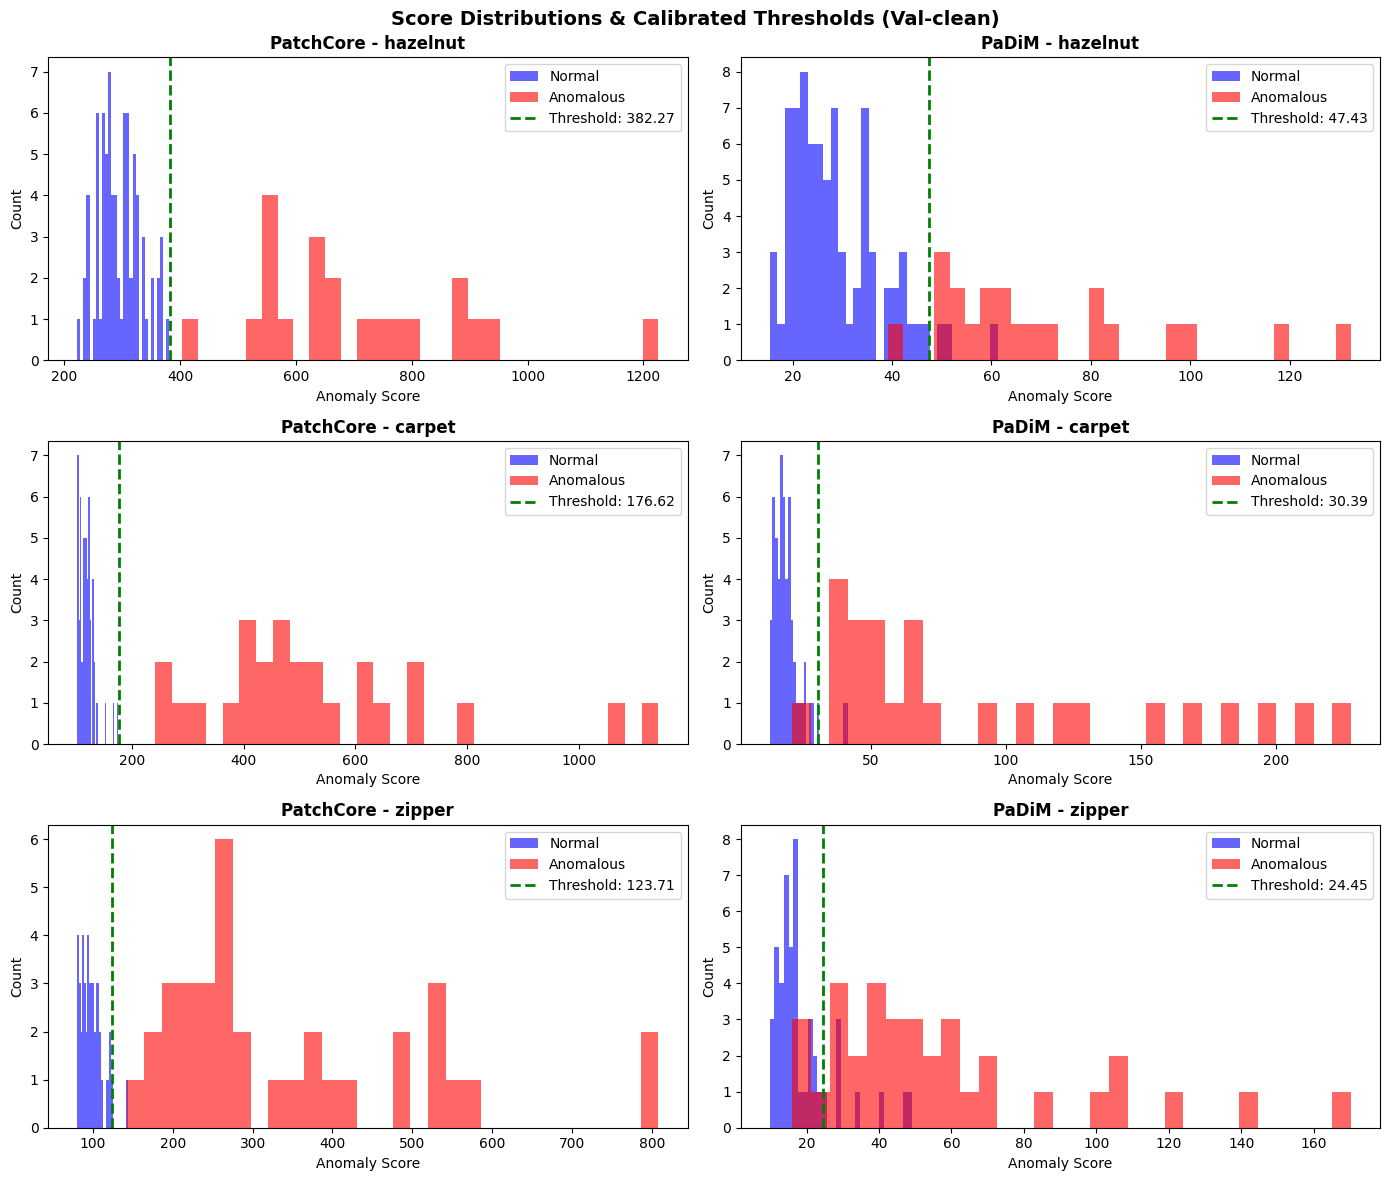

In [7]:
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(14, 4*len(CLASSES)))

for i, class_name in enumerate(CLASSES):
    # PatchCore
    ax1 = axes[i, 0]
    pc_data = calibration_data['patchcore'][class_name]
    normal_scores = pc_data['scores'][pc_data['labels'] == 0]
    anomalous_scores = pc_data['scores'][pc_data['labels'] == 1]

    ax1.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue')
    ax1.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red')
    ax1.axvline(pc_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pc_data["threshold"]:.2f}')
    ax1.set_title(f'PatchCore - {class_name}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Anomaly Score')
    ax1.set_ylabel('Count')
    ax1.legend()

    # PaDiM
    ax2 = axes[i, 1]
    pd_data = calibration_data['padim'][class_name]
    normal_scores = pd_data['scores'][pd_data['labels'] == 0]
    anomalous_scores = pd_data['scores'][pd_data['labels'] == 1]

    ax2.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue')
    ax2.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red')
    ax2.axvline(pd_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pd_data["threshold"]:.2f}')
    ax2.set_title(f'PaDiM - {class_name}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Anomaly Score')
    ax2.set_ylabel('Count')
    ax2.legend()

plt.suptitle('Score Distributions & Calibrated Thresholds (Val-clean)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'score_distributions_val_clean.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Image-Level Evaluation (Test-clean)

Now we evaluate on the test set using the calibrated thresholds.

In [8]:
transform = get_clean_transforms(image_size=config.dataset.image_size)

# Load models and evaluate on test set
all_results = {
    'patchcore': {},
    'padim': {}
}

Evaluate **PatchCore** on each class

In [9]:
for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

    # Load model
    model = PatchCore(
        backbone_layers=config.patchcore.layers,
        patch_size=config.patchcore.patch_size,
        coreset_ratio=config.patchcore.coreset_sampling_ratio,
        n_neighbors=config.patchcore.n_neighbors,
        device=DEVICE
    )
    model.load(PATCHCORE_MODELS_DIR, class_name, domain='clean')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get threshold
    threshold = patchcore_calibrator.get_threshold(class_name)

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['patchcore'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold: {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")


--- HAZELNUT ---
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Testing hazelnut:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold: 382.2659
  AUROC: 1.0000
  AUPRC: 1.0000
  F1: 1.0000
  Pixel AUROC: 0.9884817452955538
  PRO: 0.8549192206704181

--- CARPET ---


Testing carpet:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold: 176.6249
  AUROC: 0.9728
  AUPRC: 0.9908
  F1: 0.9508
  Pixel AUROC: 0.9879720503838123
  PRO: 0.836230093403762

--- ZIPPER ---


Testing zipper:   0%|          | 0/15 [00:00<?, ?it/s]

  Threshold: 123.7072
  AUROC: 0.9818
  AUPRC: 0.9935
  F1: 0.9486
  Pixel AUROC: 0.9859383046855453
  PRO: 0.832782609052772


Evaluate **PaDiM** on each class



In [10]:
for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

    # Load model
    model = PadimWrapper(
        backbone=config.padim.backbone,
        layers=config.padim.layers,
        n_features=config.padim.n_features,
        image_size=config.dataset.image_size,
        device=DEVICE
    )
    model.load(PADIM_MODELS_DIR / f'padim_{class_name}_clean.pt')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            if isinstance(scores, np.ndarray):
                all_scores.extend(scores.flatten().tolist())
            else:
                all_scores.append(float(scores))
            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            if heatmaps is not None:
                if heatmaps.ndim == 2:
                    all_heatmaps.append(heatmaps)
                else:
                    all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get threshold
    threshold = padim_calibrator.get_threshold(class_name)

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['padim'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold: {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")


--- HAZELNUT ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[OK] Model loaded: padim_hazelnut_clean.pt


Testing hazelnut:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold: 47.4312
  AUROC: 0.9709
  AUPRC: 0.9746
  F1: 0.8667
  Pixel AUROC: 0.963320622036934
  PRO: 0.7970306994765247

--- CARPET ---
[OK] Model loaded: padim_carpet_clean.pt


Testing carpet:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold: 30.3877
  AUROC: 0.9586
  AUPRC: 0.9845
  F1: 0.9231
  Pixel AUROC: 0.9839391999214272
  PRO: 0.5337515365127476

--- ZIPPER ---
[OK] Model loaded: padim_zipper_clean.pt


Testing zipper:   0%|          | 0/15 [00:00<?, ?it/s]

  Threshold: 24.4476
  AUROC: 0.8616
  AUPRC: 0.9419
  F1: 0.8953
  Pixel AUROC: 0.9718998741148507
  PRO: 0.7974670672675171


## 5. Macro-Average Results

Compute macro-averaged metrics

In [11]:
for method in ['patchcore', 'padim']:
    print(f"\n---{method.upper()}---")

    # Aggregate image-level
    image_metrics_per_class = {
        c: all_results[method][c]['image_level']
        for c in CLASSES
    }
    macro_image = aggregate_metrics(image_metrics_per_class)

    # Aggregate pixel-level
    pixel_metrics_per_class = {
        c: all_results[method][c]['pixel_level']
        for c in CLASSES
    }
    macro_pixel = aggregate_pixel_metrics(pixel_metrics_per_class)

    # Store
    all_results[method]['macro_average'] = {
        'image_level': macro_image,
        'pixel_level': macro_pixel
    }

    print(f"  AUROC: {macro_image.get('auroc', 'N/A'):.4f}")
    print(f"  AUPRC: {macro_image.get('auprc', 'N/A'):.4f}")
    print(f"  F1: {macro_image.get('f1', 'N/A'):.4f}")
    print(f"  Accuracy: {macro_image.get('accuracy', 'N/A'):.4f}")

    print(f"  Pixel AUROC: {macro_pixel.get('pixel_auroc', 'N/A'):.4f}")
    print(f"  PRO: {macro_pixel.get('pro', 'N/A'):.4f}")


---PATCHCORE---
  AUROC: 0.9849
  AUPRC: 0.9948
  F1: 0.9665
  Accuracy: 0.9522
  Pixel AUROC: 0.9875
  PRO: 0.8413

---PADIM---
  AUROC: 0.9304
  AUPRC: 0.9670
  F1: 0.8950
  Accuracy: 0.8704
  Pixel AUROC: 0.9731
  PRO: 0.7094


## 6. Visualizations

### ROC Curves

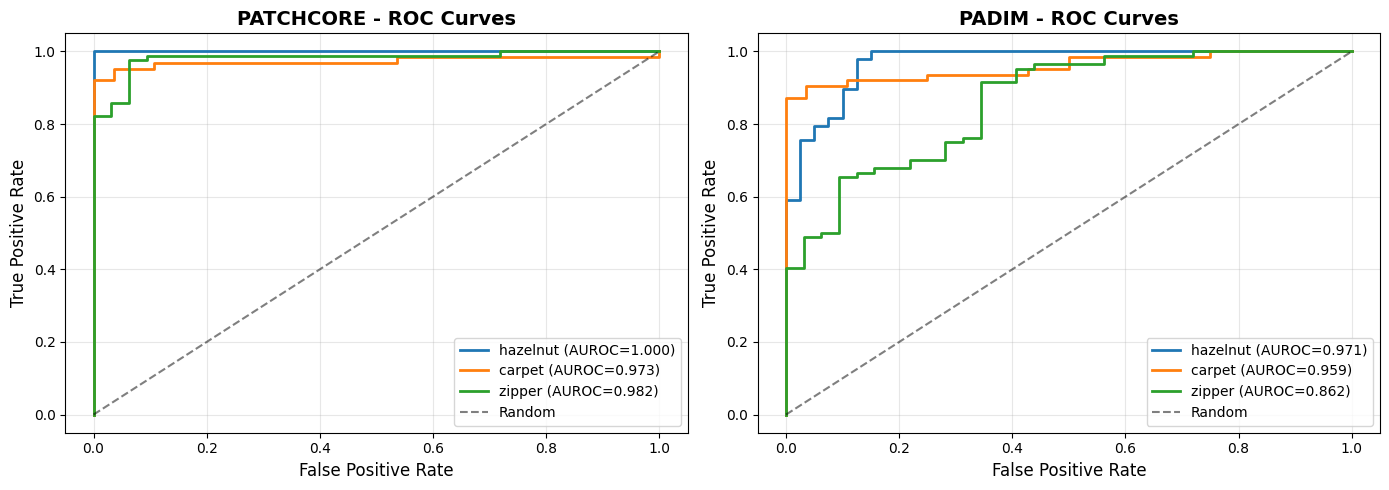

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, method in enumerate(['patchcore', 'padim']):
    ax = axes[idx]

    for class_name in CLASSES:
        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])

        fpr, tpr, _ = compute_roc_curve(labels, scores)
        auroc = all_results[method][class_name]['image_level']['auroc']

        ax.plot(fpr, tpr, label=f'{class_name} (AUROC={auroc:.3f})', linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{method.upper()} - ROC Curves', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / 'roc_curves_clean.png', dpi=150, bbox_inches='tight')
plt.show()

### Precision-Recall Curves

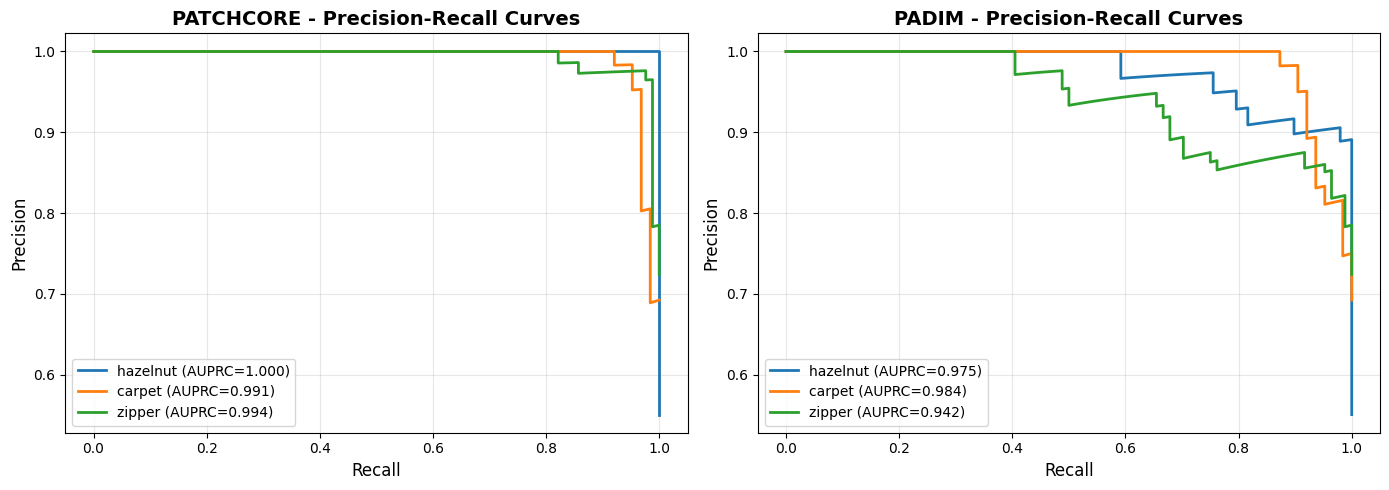

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, method in enumerate(['patchcore', 'padim']):
    ax = axes[idx]

    for class_name in CLASSES:
        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])

        precision, recall, _ = compute_pr_curve(labels, scores)
        auprc = all_results[method][class_name]['image_level']['auprc']

        ax.plot(recall, precision, label=f'{class_name} (AUPRC={auprc:.3f})', linewidth=2)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'{method.upper()} - Precision-Recall Curves', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / 'pr_curves_clean.png', dpi=150, bbox_inches='tight')
plt.show()

### Confusion Matrices

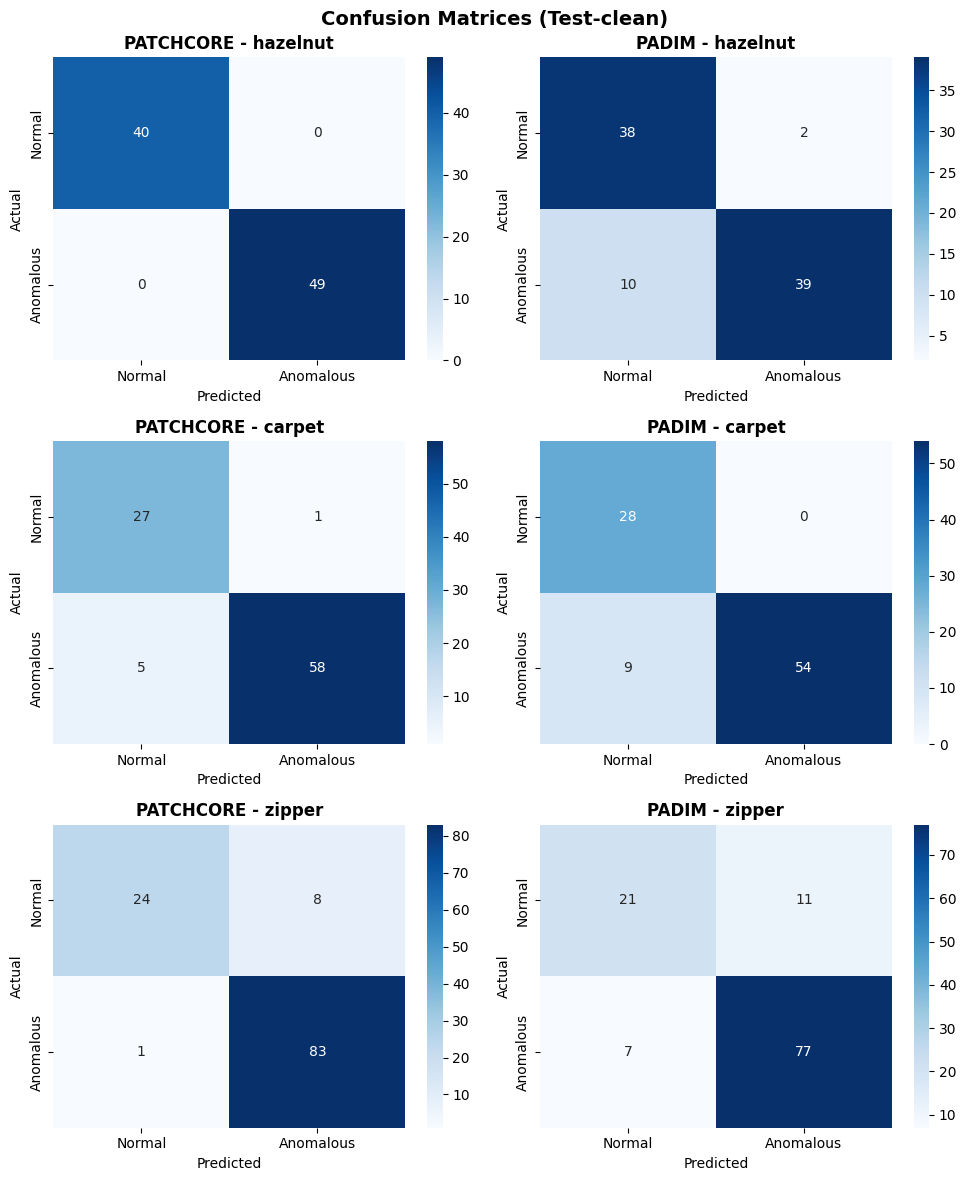

In [14]:
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(10, 4*len(CLASSES)))

for i, class_name in enumerate(CLASSES):
    for j, method in enumerate(['patchcore', 'padim']):
        ax = axes[i, j]

        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])
        threshold = all_results[method][class_name]['threshold']

        cm = compute_confusion_matrix(labels, scores, threshold)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Normal', 'Anomalous'],
                    yticklabels=['Normal', 'Anomalous'])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{method.upper()} - {class_name}', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices (Test-clean)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'confusion_matrices_clean.png', dpi=150, bbox_inches='tight')
plt.show()

### Comparison Bar Plot

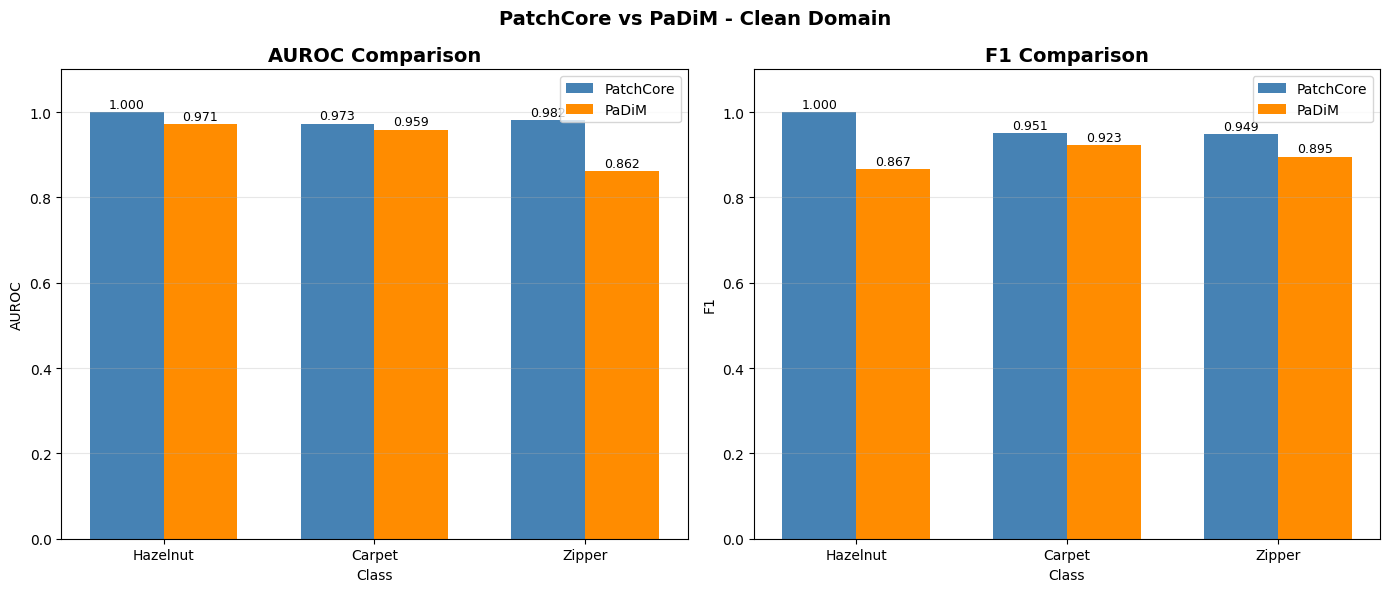

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

metrics_to_plot = ['auroc', 'auprc', 'f1', 'accuracy']
x = np.arange(len(CLASSES))
width = 0.35

for idx, metric in enumerate(['auroc', 'f1']):
    ax = axes[idx]

    pc_values = [all_results['patchcore'][c]['image_level'][metric] for c in CLASSES]
    pd_values = [all_results['padim'][c]['image_level'][metric] for c in CLASSES]

    bars1 = ax.bar(x - width/2, pc_values, width, label='PatchCore', color='steelblue')
    bars2 = ax.bar(x + width/2, pd_values, width, label='PaDiM', color='darkorange')

    ax.set_xlabel('Class')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([c.capitalize() for c in CLASSES])
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

plt.suptitle('PatchCore vs PaDiM - Clean Domain', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'method_comparison_clean.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Save Results

In [16]:
final_results = {
    'metadata': {
        'timestamp': datetime.now().isoformat(),
        'seed': 42,
        'classes': CLASSES
    },
    'patchcore': {
        class_name: {
            'threshold': all_results['patchcore'][class_name]['threshold'],
            'image_level': all_results['patchcore'][class_name]['image_level'],
            'pixel_level': all_results['patchcore'][class_name]['pixel_level']
        }
        for class_name in CLASSES
    },
    'padim': {
        class_name: {
            'threshold': all_results['padim'][class_name]['threshold'],
            'image_level': all_results['padim'][class_name]['image_level'],
            'pixel_level': all_results['padim'][class_name]['pixel_level']
        }
        for class_name in CLASSES
    }
}

# Add macro-averages
final_results['patchcore']['macro_average'] = all_results['patchcore']['macro_average']
final_results['padim']['macro_average'] = all_results['padim']['macro_average']

# Save
results_path = RESULTS_DIR / 'clean_results.json'
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\n[OK] Results saved to: {results_path}")
print(f"[OK] Visualizations saved to: {VIZ_DIR}")


[OK] Results saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/evaluation_clean/clean_results.json
[OK] Visualizations saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/evaluation_clean


## 8. Summary Table

In [17]:
import pandas as pd

# Create summary dataframe
rows = []
for method in ['patchcore', 'padim']:
    for class_name in CLASSES + ['macro_average']:
        if class_name == 'macro_average':
            img = all_results[method]['macro_average']['image_level']
            pix = all_results[method]['macro_average']['pixel_level']
            threshold = '-'
        else:
            img = all_results[method][class_name]['image_level']
            pix = all_results[method][class_name]['pixel_level']
            threshold = all_results[method][class_name]['threshold']

        rows.append({
            'Method': method.upper(),
            'Class': class_name.capitalize(),
            'Threshold': threshold if isinstance(threshold, str) else f'{threshold:.2f}',
            'AUROC': f"{img.get('auroc', 0):.4f}",
            'AUPRC': f"{img.get('auprc', 0):.4f}",
            'F1': f"{img.get('f1', 0):.4f}",
            'Accuracy': f"{img.get('accuracy', 0):.4f}",
            'Pixel AUROC': f"{pix.get('pixel_auroc', 0):.4f}" if pix.get('pixel_auroc') else '-',
            'PRO': f"{pix.get('pro', 0):.4f}" if pix.get('pro') else '-'
        })

df = pd.DataFrame(rows)
print("\n" + "=" * 100)
print("FINAL RESULTS SUMMARY - CLEAN DOMAIN")
print("=" * 100)
print(df.to_string(index=False))

# Save as CSV
df.to_csv(RESULTS_DIR / 'clean_results_summary.csv', index=False)
print(f"\n[OK] Summary saved to: {RESULTS_DIR / 'clean_results_summary.csv'}")


FINAL RESULTS SUMMARY - CLEAN DOMAIN
   Method         Class Threshold  AUROC  AUPRC     F1 Accuracy Pixel AUROC    PRO
PATCHCORE      Hazelnut    382.27 1.0000 1.0000 1.0000   1.0000      0.9885 0.8549
PATCHCORE        Carpet    176.62 0.9728 0.9908 0.9508   0.9341      0.9880 0.8362
PATCHCORE        Zipper    123.71 0.9818 0.9935 0.9486   0.9224      0.9859 0.8328
PATCHCORE Macro_average         - 0.9849 0.9948 0.9665   0.9522      0.9875 0.8413
    PADIM      Hazelnut     47.43 0.9709 0.9746 0.8667   0.8652      0.9633 0.7970
    PADIM        Carpet     30.39 0.9586 0.9845 0.9231   0.9011      0.9839 0.5338
    PADIM        Zipper     24.45 0.8616 0.9419 0.8953   0.8448      0.9719 0.7975
    PADIM Macro_average         - 0.9304 0.9670 0.8950   0.8704      0.9731 0.7094

[OK] Summary saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/evaluation_clean/clean_results_summary.csv


## Files Generated

This notebook generates the following files:

- **Results** (`outputs/results/`)
    - `clean_results.json`: Complete evaluation results in JSON format with all metrics per model and class
    - `clean_results_summary.csv`: Summary table with image-level and pixel-level metrics for all models/classes
- **Thresholds** (`outputs/thresholds/`)
    - `patchcore_clean_thresholds.json`: F1-optimal thresholds calibrated on validation set for PatchCore
    - `padim_clean_thresholds.json`: F1-optimal thresholds calibrated on validation set for PaDiM
- **Visualizations** (`outputs/visualizations/phase5_clean/`)
    - `score_distribution_{model}_{class}.png`: Anomaly score distributions for normal vs anomalous samples
    - `roc_curve_{model}_{class}.png`: ROC curves with AUC values (image-level)
    - `pr_curve_{model}_{class}.png`: Precision-Recall curves with AUPRC values
    - `confusion_matrix_{model}_{class}.png`: Confusion matrices at optimal threshold
    - `method_comparison.png`: Bar chart comparing PatchCore vs PaDiM across classes


In [18]:
import shutil
import os

# Destination folder on Google Drive
OUTPUT_DRIVE_DIR = DRIVE_ROOT / '06_evaluation_clean_outputs'

# List of specific result files to save
FILES_TO_SAVE = [
    (RESULTS_DIR, 'clean_results_summary.csv'),
    (RESULTS_DIR, 'clean_results.json'),
    (THRESHOLDS_DIR, 'patchcore_clean_thresholds.json'),
    (THRESHOLDS_DIR, 'padim_clean_thresholds.json')
]

# Specific visualization directory for this phase
VIZ_SOURCE_DIR = VIZ_DIR

# Create base destination directory
if not os.path.exists(OUTPUT_DRIVE_DIR):
    os.makedirs(OUTPUT_DRIVE_DIR, exist_ok=True)

# 1. Save specific files (Results & Thresholds) directly to OUTPUT_DRIVE_DIR
print("\n[Files]")
for source_dir, filename in FILES_TO_SAVE:
    src = source_dir / filename
    dst = OUTPUT_DRIVE_DIR / filename # Save directly to the main output directory

    if os.path.exists(src):
        try:
            shutil.copy2(src, dst)
            print(f"  -> Saved: {filename}")
        except Exception as e:
            print(f"  -> Error saving {filename}: {e}")
    else:
        print(f"  -> Warning: File not found {filename}")

# 2. Save Visualizations directly to OUTPUT_DRIVE_DIR
print("\n[Visualizations]")
if os.path.exists(VIZ_SOURCE_DIR):
    viz_files = [f for f in os.listdir(VIZ_SOURCE_DIR) if os.path.isfile(os.path.join(VIZ_SOURCE_DIR, f))]
    if viz_files:
        for viz_filename in viz_files:
            src_viz = VIZ_SOURCE_DIR / viz_filename
            dst_viz = OUTPUT_DRIVE_DIR / viz_filename # Save directly to the main output directory
            try:
                shutil.copy2(src_viz, dst_viz)
                print(f"  -> Saved visualization: {viz_filename}")
            except Exception as e:
                print(f"  -> Error saving visualization {viz_filename}: {e}")
        print(f"  -> Saved {len(viz_files)} visualization images.")
    else:
        print("  -> No visualization files found to save.")
else:
    print("  -> Warning: Visualization directory not found.")



[Files]
  -> Saved: clean_results_summary.csv
  -> Saved: clean_results.json
  -> Saved: patchcore_clean_thresholds.json
  -> Saved: padim_clean_thresholds.json

[Visualizations]
  -> Saved visualization: confusion_matrices_clean.png
  -> Saved visualization: score_distributions_val_clean.png
  -> Saved visualization: roc_curves_clean.png
  -> Saved visualization: pr_curves_clean.png
  -> Saved visualization: method_comparison_clean.png
  -> Saved 5 visualization images.
